## AESMC for a planar arm
### Infer latent joint angles given noisy coordinates
The first part of this notebook validates that with a fixed transition and emission models, we can infer the latent variables using SMC. That is, only inference, without parameter learning. We use the Bootstrap proposal, sampling "particles" from the transition model and weighing them by the probability of explaining the data.

In the second part, we learn the static parameters that appear in the emission distribution.

In the third part, we will learn the parameters of a proposal distribution that maps the previous latents and observations, through a neural network to parameters of a normal distribution from which we take samples.

In [1]:
import aesmc.train as train
import aesmc.losses as losses
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from arm_models import forward_kin_2D
from arm_models import arm_utils
from aesmc import statistics

In [2]:
# define global params which we're not ineferring 
# potentially learn or make sure you got them right
transition_scale = 0.2
emission_scale = 0.05
proposal_scale_0 = 1
proposal_scale_t = 0.1
# define initial params for training
L1_init = 1.0
L2_init = 1.0
initial_loc = torch.zeros(2)
initial_scale = 1 # * torch.eye(2)
init_transition_mult = 0
init_emission_mult = 0
# define true params (to simualte data from)
L1_true = 1.0
L2_true = 1.0
true_transition_mult = 1
true_emission_mult = 1
# define train/infer params
num_timesteps = 100
num_test_obs = 10
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 100

In [3]:
dataloader = train.get_synthetic_dataloader(
            forward_kin_2D.Initial(initial_loc, initial_scale),
            forward_kin_2D.Transition(true_transition_mult, transition_scale),
            forward_kin_2D.Emission(forward_kin_2D.FW_kin_2D, 
                                    L1_true, L2_true, emission_scale, learn_static = True),
            num_timesteps, batch_size)

In [4]:
# test how the simulated observations look like
# note that the observations in the current spyder file look differently
num_iter_check=3
for epoch_iteration_idx, observations in enumerate(dataloader):
    if epoch_iteration_idx == num_iter_check:
                    break
                
print(observations[-1].size())
print('should be [batch_size, dim_observation]')

torch.Size([10, 6])
should be [batch_size, dim_observation]


In [5]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in observations], dim=2)
print(sim_data.shape)
print('should be [batch_size, dim_observation, num_timesteps]')

torch.Size([10, 6, 100])
should be [batch_size, dim_observation, num_timesteps]


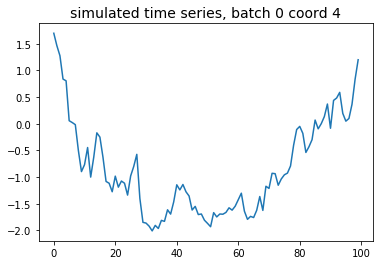

In [6]:
# plot simulated time series for one coordinate
coord_ind = 4
batch_ind = 0
plt.plot(sim_data.detach().numpy()[batch_ind, coord_ind,:]);
plt.title('simulated time series, batch %i coord %i' %(batch_ind, coord_ind), fontsize=14);
# ToDo: would like to get the video of the 2D arm. would also like to access latents

In [7]:
# inspect statistics.sample_from_prior
'''this function has access to latents and observations. '''
a,b = statistics.sample_from_prior(forward_kin_2D.Initial(initial_loc, initial_scale),
                              forward_kin_2D.Transition(true_transition_mult, transition_scale),
                              forward_kin_2D.Emission(forward_kin_2D.FW_kin_2D, 
                                 L1_init, L2_init, emission_scale, learn_static = True), num_timesteps,
                                         batch_size)
print(a[-1].size()) # [batch_size, dim_latents]
print(b[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 2])
torch.Size([10, 6])


In [8]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in a], dim=2)
lat_data.shape

torch.Size([10, 2, 100])

In [9]:
initial = forward_kin_2D.Initial(initial_loc, initial_scale)
transition = forward_kin_2D.Transition(true_transition_mult, transition_scale)
emission = forward_kin_2D.Emission(forward_kin_2D.FW_kin_2D, 
                        L1_true, L2_true, emission_scale, False)
# model with more elaborate proposal, parameters need to be trained.
# proposal = forward_kin_2D.Proposal(proposal_scale_0,
#                                     proposal_scale_t)
# model with bootstrap proposal
# note that in the scales could be twice as large as in the true transition and it'll infer things properly
proposal = forward_kin_2D.Bootstrap_Proposal(initial_scale, initial_loc, 
                                             transition_scale, true_transition_mult)

In [10]:
# # make up a list of inferred latents
# the dim should be [batch_size, num_particles, dim_latents]
inferred_latents_list = []
for i in range(num_timesteps):
    inferred_latents_list.append(torch.rand([batch_size, num_particles, 2]))
print(len(inferred_latents_list))
print(inferred_latents_list[-1].shape)

100
torch.Size([10, 100, 2])


In [11]:
print(initial)
print(transition)
print(emission)
print(proposal)

Transition()
Emission()
Bootstrap_Proposal()


In [12]:
print(proposal(time=0, observations=observations)) # first call
print(proposal(time=2, previous_latents= inferred_latents_list, observations=observations)) # second call
# note that the inferred latents_list is longer than needed and not appropriate

Normal(loc: torch.Size([10, 2]), scale: torch.Size([10, 2]))
Normal(loc: torch.Size([10, 100, 2]), scale: torch.Size([10, 100, 2]))


In [13]:
from aesmc import inference

inference_result = inference.infer(
            inference_algorithm='smc',
            observations=b, # USE OBSERVATIONS- b is temporary. created above when we played with creating data
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=1000
        )

In [14]:
print(len(inference_result))

7


that's it, inference seems to run properly! let's check if it is indeed making sense.

In [15]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(statistics.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(statistics.empirical_variance(
        latent, inference_result['log_weight']
    ))

In [16]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in b], dim=2) # now b, should be obs in observations
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=2)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=2)

In [17]:
smooth_mean.shape

torch.Size([10, 2, 100])

In [18]:
ind_in_batch = 4
dim_lat_plot = 0
np.max(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy()) # 0! it's also not on the same scale

0.0025463104

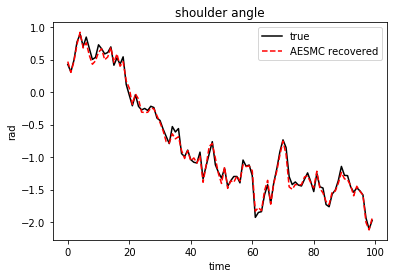

In [19]:
ind_in_batch = 6 # could be between 0 and batch_size-1
dim_lat_plot = 0
plt.plot(lat_data[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'black', label="true");
plt.plot(smooth_mean[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'red', 
         linestyle = 'dashed', label = "AESMC recovered");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('shoulder angle')
plt.ylabel('rad')
plt.xlabel('time')
plt.legend();
#plt.savefig('first_fig_aesmc.png')

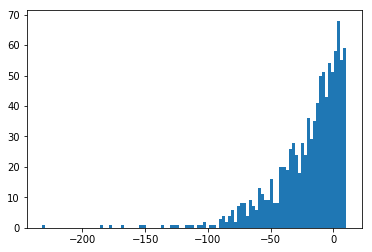

In [20]:
plt.hist(inference_result["log_weight"][0,:].detach().numpy(), bins=100);

In [21]:
# predicted coordinates
ind_in_batch = 8 # could be between 0 and batch_size-1
x_hat , y_hat = arm_utils.coords_from_params_mat(smooth_mean[ind_in_batch,0,:].detach().numpy(), 
                                       smooth_mean[ind_in_batch,1,:].detach().numpy(), L1_true, L2_true)

In [22]:
x_obs = sim_data[ind_in_batch, [0,2,4], :].detach().numpy().T
y_obs = sim_data[ind_in_batch, [1,3,5], :].detach().numpy().T

In [23]:
# print(y_obs.shape)
# print(x_hat.shape)

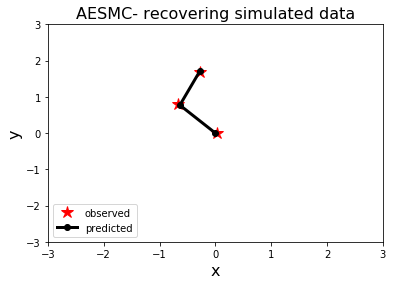

In [46]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, x_hat, y_hat, 'FW-KIN-2D_plots/fw-kin-2d-recovered', 
                   "AESMC- recovering simulated data", x_hat.shape[0], L1_true + L2_true + 1)

In [ ]:
# ind_in_batch = 5 # could be between 0 and batch_size-1
# plt.plot(sim_data[ind_in_batch,:].detach().numpy(), 
#          label = '$x$', color = 'gray', linewidth=2)
# plt.plot(smooth_data[ind_in_batch,:].detach().numpy(), 
#          label = '$\mathbb{E}[z|x]$', color = 'red', linewidth=1)
# plt.fill_between(
#             np.arange(num_timesteps),
#             smooth_mean[ind_in_batch,:].detach().numpy() -
#             np.sqrt(smooth_var[ind_in_batch,:].detach().numpy()),
#             smooth_mean[ind_in_batch,:].detach().numpy() +
#             np.sqrt(smooth_var[ind_in_batch,:].detach().numpy()),
#             alpha=0.8,
#             color='gray'
#         )
# plt.legend();

In [33]:
# if we wanna train try that here
num_iterations = 600 # override previous statements. ToDo: define those here

training_stats = forward_kin_2D.TrainingStats(
                initial_loc, initial_scale, true_transition_mult,
                transition_scale,  L1_true, L2_true, emission_scale,
                num_timesteps, num_test_obs, test_inference_num_particles,
                saving_interval, logging_interval)

train.train(dataloader=dataloader, # loads ground truth observations
            num_particles=num_particles,
            algorithm='aesmc',
            initial=initial,
            transition=transition,
            emission= forward_kin_2D.Emission(forward_kin_2D.FW_kin_2D, 
                        0.7, 1.2, emission_scale, True), # trainable
            proposal=proposal,
            num_epochs=1,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

Iteration 0: Loss = 2288.419921875
0.7009999752044678
0.36
Iteration 10: Loss = 1483.375244140625
0.7109480500221252
0.35
Iteration 20: Loss = 1901.817138671875
0.720813512802124
0.33
Iteration 30: Loss = 1812.079345703125
0.7306028008460999
0.32
Iteration 40: Loss = 1282.349609375
0.7401880621910095
0.31
Iteration 50: Loss = 998.4625854492188
0.7495774030685425
0.3
Iteration 60: Loss = 884.6585693359375
0.7588164210319519
0.29
Iteration 70: Loss = 1121.002197265625
0.7679347991943359
0.27
Iteration 80: Loss = 887.4382934570312
0.776839554309845
0.26
Iteration 90: Loss = 718.6417236328125
0.7855589985847473
0.25
Iteration 100: Loss = 742.7118530273438
0.7940768599510193
0.24
Iteration 110: Loss = 508.52069091796875
0.8024902939796448
0.23
Iteration 120: Loss = 395.66455078125
0.8106695413589478
0.22
Iteration 130: Loss = 294.18115234375
0.8185823559761047
0.21
Iteration 140: Loss = 410.48516845703125
0.826337456703186
0.2
Iteration 150: Loss = 152.9845428466797
0.8339644074440002
0.19


In [34]:
L1_in_train = np.asarray(training_stats.curr_L1)
L2_in_train = np.asarray(training_stats.curr_L2)

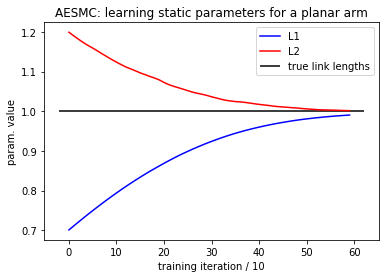

In [45]:
plt.hlines(xmin=-2, xmax=62, y=1, label = "true link lengths")
plt.plot(L1_in_train, label= "L1", color = 'blue')
plt.plot(L2_in_train, label="L2", color = 'red')
plt.xlabel("training iteration / 10")
plt.ylabel("param. value")
plt.title('AESMC: learning static parameters for a planar arm')
plt.legend();
plt.savefig('FW-KIN-2D_plots/fw-kin-2d-stat-param.png')

In [107]:
# ToDo: define Proposal class here once and then delegate to the main script once your happy with the results
class Proposal(nn.Module):
    def __init__(self, scale_0, scale_t):
        super(Proposal, self).__init__()
        self.scale_0 = scale_0
        self.scale_t = scale_t
        self.lin_0 = nn.Linear(6, 2) # observations[0] -> mu[0]
        self.lin_t = nn.Linear(8, 2) # {previous_latents[t-1], observations[t]} -> mu[t]

    def forward(self, previous_latents=None, time=None, observations=None):
        if time == 0:
            return aesmc.state.set_batch_shape_mode(
                torch.distributions.Normal(
                    loc=self.lin_0(observations[0]),
                    scale=self.scale_0),
                aesmc.state.BatchShapeMode.BATCH_EXPANDED)
        else:
            batch_size, num_particles, dim_latents = previous_latents[-1].shape
            expanded_obs = aesmc.state.expand_observation(observations[time], num_particles) # expand current obs
            # concat previous latents with current expanded observation. then squeeze to batch_expanded mode
            # i.e., [batch_size*num_particles, dim_latent+dim_observation]
            # to apply a linear layer.
            concat_squeezed = torch.cat([previous_latents[-1], 
                        expanded_obs
                        ], 
                        dim=2).view(-1, previous_latents[-1].shape[2]+ expanded_obs.shape[2])
            activ = self.lin_t(concat_squeezed)
            mu_t = activ.view(batch_size, num_particles, dim_latents)
            return aesmc.state.set_batch_shape_mode(
                torch.distributions.Normal(
                    loc=mu_t,
                    scale=self.scale_t),
                aesmc.state.BatchShapeMode.FULLY_EXPANDED)

so need to:
at time t, use `state.expand_observation()`, then concatanate with `previous_latents[-1]`,
then compress the batch size expansion, then apply FF network, then expand to full `[batch_size, num_particles,dim_latent]`

In [9]:
proposal_instance = Proposal(proposal_scale_0, proposal_scale_t)

In [28]:
observations[0].shape

torch.Size([10, 6])

In [10]:
prop_0_mu = proposal_instance.lin_0(observations[0])
print(prop_0_mu.shape)

torch.Size([10, 2])


In [11]:
import aesmc.state as state

In [13]:
# how to expand a scalar to dimensions of interest
a = torch.rand(10,2)
b = torch.tensor(1)
b.expand(a.shape).shape

torch.Size([10, 2])

In [15]:
# at time t=0 (this will go inside the proposal forward method)
# ToDo: check if we prefer/can have a MVN with covariance
distr_obj_0 = state.set_batch_shape_mode(
                torch.distributions.Normal(
                    loc=prop_0_mu,
                    scale=torch.tensor(initial_scale).expand(prop_0_mu.shape)),
                state.BatchShapeMode.BATCH_EXPANDED)
print(distr_obj_0)

Normal(loc: torch.Size([10, 2]), scale: torch.Size([10, 2]))


In [98]:
# we would like to keep these dimesions, expand the observations to be 
# [batch_size, num_particles, dim_observations] and then concatanate 
print(observations[0].shape)
print(observations[0].view(-1, 1, 6).shape)
print(observations[0][0,:])
print(observations[0].view(-1, 1, 6)[0,0,:])
print(observations[0].view(-1, 1, 6).expand(10,num_particles,6).shape)
print("that is [batch_size, num_particles, dim_observations]")
print(observations[0].view(-1, 1, 6).expand(10,num_particles,6)[0,89,:]) # 0th batch, 89th particle, all obs dims
cat = torch.cat([inferred_latents_list[-1], 
           observations[0].view(-1, 1, 6).expand(10,num_particles,6)
                ], 
                dim=2)
print(cat.shape) # print out cat vals below
print("that is [batch_size, num_particles, dim_observations + dim_latents]")
print("now we have to push things through a linear layer")
print("so first view in two dimensions [batch_size*num_particles, dim_observations + dim_latents]")
print(cat.view(-1,8).shape)
print("push through FF layer")
activ = proposal_instance.lin_t(cat.view(-1,8))
print(activ.shape)
print("get [batch_size*num_particles, dim_latents], and reshape again to canonical form")
print(activ.view(batch_size,num_particles,2).shape)
prop_t_mu = activ.view(batch_size,num_particles,2)

torch.Size([10, 6])
torch.Size([10, 1, 6])
tensor([-0.0062, -0.0019,  0.3602, -0.9463,  1.2763, -1.3362])
tensor([-0.0062, -0.0019,  0.3602, -0.9463,  1.2763, -1.3362])
torch.Size([10, 100, 6])
that is [batch_size, num_particles, dim_observations]
tensor([-0.0062, -0.0019,  0.3602, -0.9463,  1.2763, -1.3362])
torch.Size([10, 100, 8])
that is [batch_size, num_particles, dim_observations + dim_latents]
now we have to push things through a linear layer
so first view in two dimensions [batch_size*num_particles, dim_observations + dim_latents]
torch.Size([1000, 8])
push through FF layer
torch.Size([1000, 2])
get [batch_size*num_particles, dim_latents], and reshape again to canonical form
torch.Size([10, 100, 2])


In [106]:
distr_obj_t = state.set_batch_shape_mode(
                torch.distributions.Normal(
                    loc=prop_t_mu,
                    scale=proposal_scale_t),#torch.tensor(proposal_scale_t).expand(prop_t_mu.shape)),
                state.BatchShapeMode.FULLY_EXPANDED)
print(distr_obj_t)
#print(distr_obj_t.scale)
# same output obtained by expanding
# distr_obj_t = state.set_batch_shape_mode(
#                 torch.distributions.Normal(
#                     loc=prop_t_mu,
#                     scale=torch.tensor(proposal_scale_t).expand(prop_t_mu.shape)),
#                 state.BatchShapeMode.FULLY_EXPANDED)
# print(distr_obj_t.scale)

Normal(loc: torch.Size([10, 100, 2]), scale: torch.Size([10, 100, 2]))


In [64]:
# we could also use state.expand_observation and its fine
# ToDo -- add state.compress to batch_expanded mode
expanded_obs = state.expand_observation(observations[0], num_particles)
print(expanded_obs.shape)
print(torch.max(observations[0].view(-1, 1, 6).expand(10,num_particles,6)-expanded_obs))

torch.Size([10, 100, 6])
tensor(0.)


In [93]:
lin_toy = torch.tensor([[0,0],[1,10]])
print(lin_toy)
print(lin_toy.shape)
# both units see just the second column of the input (for each batch). 
# the second unit scales the second column by ten

tensor([[ 0,  0],
        [ 1, 10]])
torch.Size([2, 2])


In [94]:
# want to have full batch size mode, and view it in different ways and see what happens
vec_tens = torch.tensor(np.arange(8))
print(vec_tens)
vec_tens_full_expanded = vec_tens.view(2,2,2)
print(vec_tens_full_expanded)
vec_tens_batch_expanded = vec_tens_full_expanded.view(4,2)
print(vec_tens_batch_expanded)
vec_tens_full_expanded_2 = vec_tens_batch_expanded.view(2,2,2)
print(vec_tens_full_expanded_2)
print(torch.max(vec_tens_full_expanded-vec_tens_full_expanded_2))

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]])
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])
tensor(0)


In [97]:
print(vec_tens_batch_expanded.shape)
matmul_batch = torch.mm(vec_tens_batch_expanded,lin_toy)
print(matmul_batch)
print(matmul_batch.shape)
print(matmul_batch.view(2,2,2))
print(matmul_batch.view(2,2,2)[0,:,:])
print("compare to the zero-th batch in the input:" )
print(vec_tens_full_expanded[0,:,:])
print("and we see that the two output units do what we expect for that batch")

torch.Size([4, 2])
tensor([[ 1, 10],
        [ 3, 30],
        [ 5, 50],
        [ 7, 70]])
torch.Size([4, 2])
tensor([[[ 1, 10],
         [ 3, 30]],

        [[ 5, 50],
         [ 7, 70]]])
tensor([[ 1, 10],
        [ 3, 30]])
compare to the zero-th batch in the input:
tensor([[0, 1],
        [2, 3]])
and we see that the two output units do what we expect for that batch


In [91]:
vec_tens_full_expanded[0,0,:]

tensor([0, 1])

In [20]:
# at some later time: 
# note that we cannot play this game with forward 'latents' unless we have access to the particles; so it has
# to be 'inference_result['latents']''.
time = 16
num_particles = inferred_latents_list[time-1].shape[1]
prop_t_mu = proposal_instance.lin_t()
# prop_t_mu = lin_t(torch.cat(
#                     [inference_result['latents'][time-1].unsqueeze(-1),
#                      observations[time].view(-1, 1, 1).expand(
#                         -1, num_particles, 1
#                      )],
#                     dim=2
#                 ).view(-1, 2)).squeeze(-1).view(-1, num_particles)
# print(prop_t_mu.shape)

In [21]:
num_particles

100

In [27]:
# print the intermediate reshapes from the lgssm case:
print(observations[time].shape)
print(observations[time].view(-1, 1, 1).shape)
print(observations[time].view(-1, 1, 1).expand(
                         -1, num_particles, 1
                     ).shape)
print('it seems that these dimensions do not make sense in our case')

torch.Size([10, 6])
torch.Size([60, 1, 1])
torch.Size([60, 100, 1])
it seems that these dimensions do not make sense in our case
